In [ ]:
#===============================================================================
#---Import all the required libraries

import os
import zipfile
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline

In [ ]:
#===============================================================================
#---Import libraries for model building

import tensorflow as tf
import keras

import os
from pathlib import Path
from tensorflow.keras.utils import get_file
import glob

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#===============================================================================
#---Pull the dataset from url

#--PUT the dataset in the same folder in the kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d rariffirmansah/rumah-adat

 97% 689M/714M [00:08<00:00, 39.1MB/s]
100% 714M/714M [00:08<00:00, 88.4MB/s]


In [ ]:
#---Unizip the file

local_zip = '/content/rumah-adat.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')

zip_ref.close()

In [ ]:
from tensorflow.keras.utils import get_file

data_dir = '/content/rumah_adat'
directory = Path(data_dir)

print(os.listdir(directory))

for i in (os.listdir(directory)):
  image_count = len(list(directory.glob('*/*.png')))
  print('\nTotal number of images in the dataset are:', image_count)

['tongkonan', 'joglo', 'gadang', 'panjang', 'honai']

Total number of images in the dataset are: 3919

Total number of images in the dataset are: 3919

Total number of images in the dataset are: 3919

Total number of images in the dataset are: 3919

Total number of images in the dataset are: 3919


In [ ]:
#===========================================================================
#---Data Preproccessing

img_height = 224
img_width = 224
batch_size = 32
seed = 42

from tensorflow.keras.utils import image_dataset_from_directory as idfd

#-----Data splitting
#--train dataset
train_ds = idfd(
    directory,
    shuffle = True,
    label_mode = 'categorical',
    validation_split = 0.4,
    subset = 'training',
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
print("\n")
#--validation dataset
val_ds = idfd(
    directory,
    shuffle = True,
    label_mode = 'categorical',
    validation_split = 0.4,
    subset = 'validation',
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size
)



Found 3919 files belonging to 5 classes.
Using 2352 files for training.


Found 3919 files belonging to 5 classes.
Using 1567 files for validation.


In [ ]:
#---Checking data shape and number of channel
print('Memeriksa gambar dan label batch dalam hal ukurannya')

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print('\n')
num_channels = image_batch[0].ndim
print('Number of channels:', num_channels)

Memeriksa gambar dan label batch dalam hal ukurannya
(32, 224, 224, 3)
(32, 5)


Number of channels: 3


In [ ]:
#---Create test datast

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 33
Number of test batches: 16


In [ ]:
#---Rescale & Data augmentation
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

augment = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
  ]
)



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
metrics = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

In [ ]:
def evolution(model, epochs):
    epochs = range(1,epochs+1)

    plt.figure(figsize=(20, 25))

    plt.subplot(4, 2, 1)
    loss_train = model.history['loss']
    loss_val = model.history['val_loss']
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Loss Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(4, 2, 2)
    accuracy_train = model.history['accuracy']
    accuracy_val = model.history['val_accuracy']
    plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
    plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
    plt.title('Accuracy Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(4, 2, 3)
    precision_train = model.history['precision']
    precision_val = model.history['val_precision']
    plt.plot(epochs, precision_train, 'g', label='Training precision')
    plt.plot(epochs, precision_val, 'b', label='validation precision')
    plt.title('Precision Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(4, 2, 4)
    recall_train = model.history['recall']
    recall_val = model.history['val_recall']
    plt.plot(epochs, recall_train, 'g', label='Training recall')
    plt.plot(epochs, recall_val, 'b', label='validation recall')
    plt.title('Recall Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    return()


In [ ]:
from tensorflow.keras.layers import Rescaling, Flatten, Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout, Input

In [ ]:
#----Count the class number and names

class_names = train_ds.class_names
print('List of classes classes:',class_names)

num_classes = len(class_names)
print('Number of neurons in output layer:',num_classes)

List of classes classes: ['gadang', 'honai', 'joglo', 'panjang', 'tongkonan']
Number of neurons in output layer: 5


In [ ]:
#----Define the CNN model

cnn_model1 = tf.keras.models.Sequential(
[
    Input(shape= (img_height, img_width, num_channels)),
    augment,
    rescale,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
#---Comile the model
cnn_model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

#---Visualize the model summary
print(cnn_model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2, verbose=1,factor=0.3,
                                            min_lr=0.000001)

In [ ]:
3ewwwemodel1_history = cnn_model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks = [learning_rate_reduction],
)

Epoch 1/50
74/74 [==============================] - 200s 3s/step - loss: 1.6197 - accuracy: 0.2334 - precision: 0.3281 - recall: 0.0089 - val_loss: 1.5315 - val_accuracy: 0.2834 - val_precision: 0.3696 - val_recall: 0.0161 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - 195s 3s/step - loss: 1.5191 - accuracy: 0.2929 - precision: 0.5647 - recall: 0.0204 - val_loss: 1.4537 - val_accuracy: 0.3687 - val_precision: 0.7541 - val_recall: 0.0436 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - 182s 2s/step - loss: 1.3757 - accuracy: 0.4167 - precision: 0.5885 - recall: 0.0961 - val_loss: 1.4230 - val_accuracy: 0.4739 - val_precision: 0.5844 - val_recall: 0.2199 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - 193s 3s/step - loss: 1.3036 - accuracy: 0.4694 - precision: 0.6078 - recall: 0.1713 - val_loss: 1.2149 - val_accuracy: 0.4957 - val_precision: 0.6227 - val_recall: 0.2863 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - 168s

# New Section

()

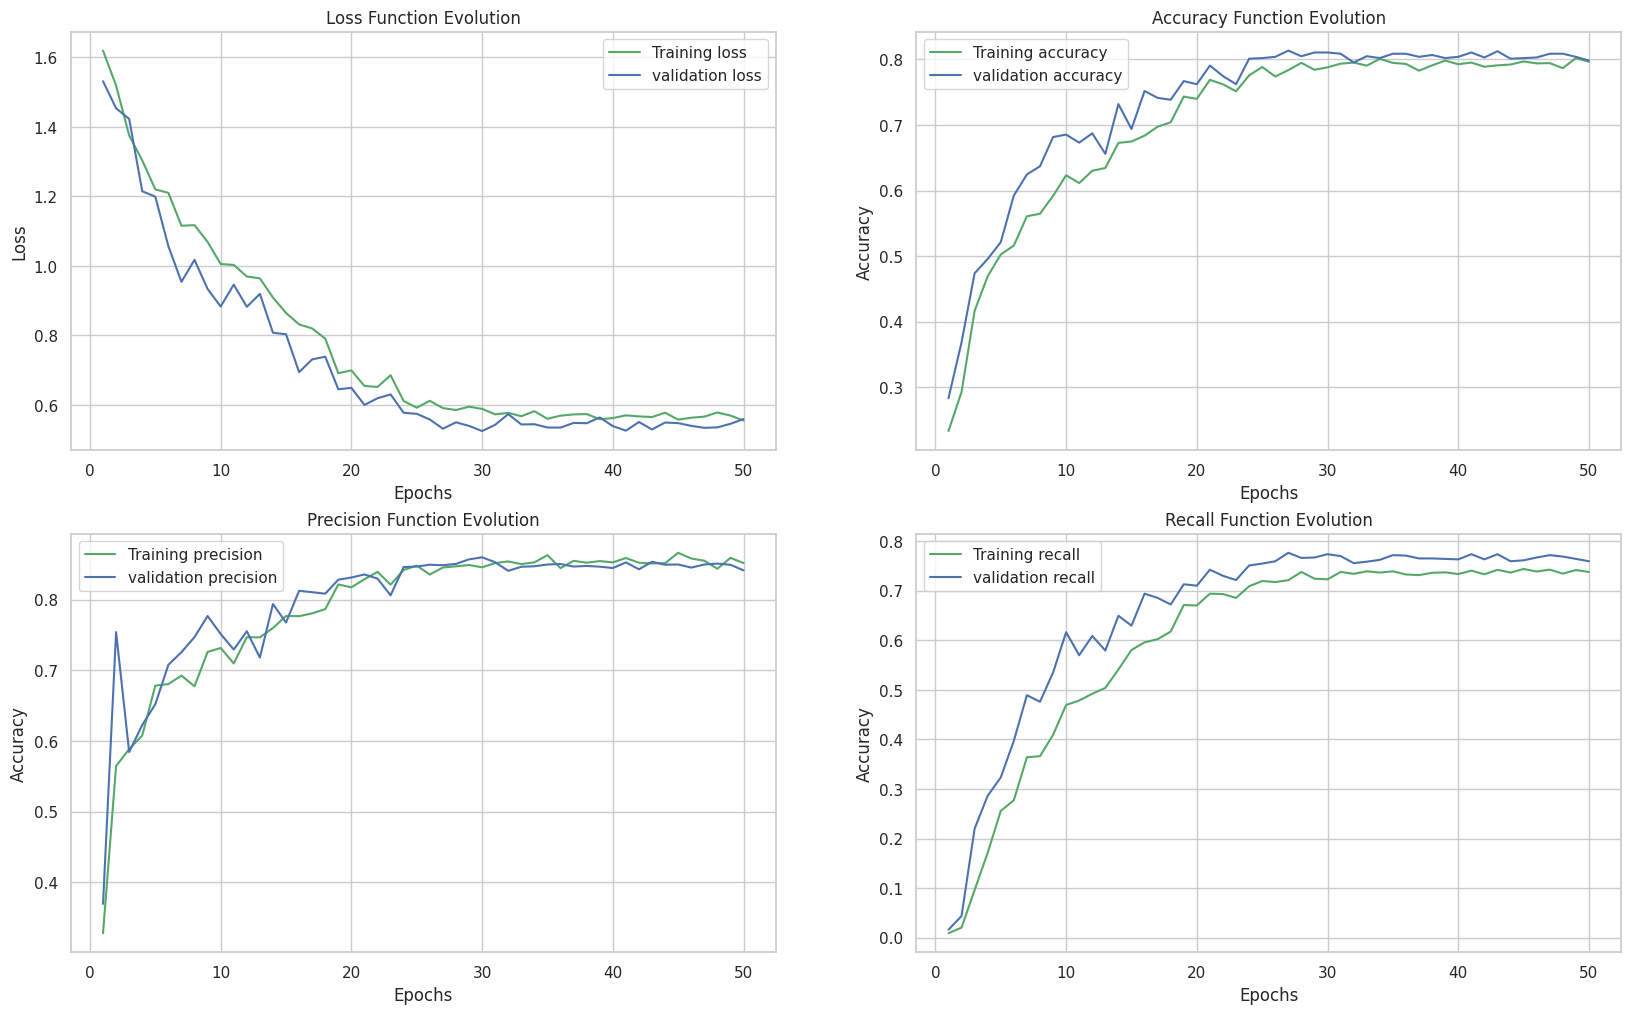

In [ ]:
#----Visualize the graph of the model training proccess
evolution(model1_history,70)

In [ ]:
#----Save the model
cnn_model1.save('cnn_model1.h5')
cnn_model1.save_weights('cnn_model1_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#----Model Prediction
from tensorflow.keras.models import load_model

#----Load the model
model_resnet = load_model('cnn_model1.h5')

#----Predict
for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model_resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print('Actual class:', class_names[np.argmax(labels[i])], '|| Predicted class: {}; with a {:.2f} percent confidence.'
          .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n')

1/1 [==============================] - 0s 167ms/step
Actual class: tongkonan || Predicted class: tongkonan; with a 39.15 percent confidence. 

1/1 [==============================] - 0s 37ms/step
Actual class: tongkonan || Predicted class: tongkonan; with a 40.00 percent confidence. 

1/1 [==============================] - 0s 34ms/step
Actual class: gadang || Predicted class: gadang; with a 39.85 percent confidence. 

1/1 [==============================] - 0s 41ms/step
Actual class: gadang || Predicted class: gadang; with a 40.11 percent confidence. 

1/1 [==============================] - 0s 35ms/step
Actual class: gadang || Predicted class: tongkonan; with a 31.79 percent confidence. 

1/1 [==============================] - 0s 35ms/step
Actual class: panjang || Predicted class: panjang; with a 35.71 percent confidence. 

1/1 [==============================] - 0s 35ms/step
Actual class: panjang || Predicted class: panjang; with a 35.79 percent confidence. 

1/1 [=======================